# Week 3 master thesis
to do:
- Get the lambda to work. And do cross validation. 
- Criteria condition analytical good the the real one. 

Big conclusion was that the lambda does indeed work, because we only use information of subsequent measurements. And indeed on subsequent measurements the noise pops out as just a filter added ontop of it! Hence we are big in the regime we where earlier. 

I first want to achieve the following: I first want explore the difference between the points and try to substract the model from it such that we are left with purely the noise terms.

## Exploration subsequent points

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
import sys # for reloading
import time
# import self made models
from W3_glv_minimal_code import * # generates Timeseries
from W3_gradient_descent import *# gradient descent algorithm
from W3_Functions import * # contains all important functions that were defined in week 2

Small side note: I also let the starting position of the time series be seed dependend. So now it should be 100 % fixed

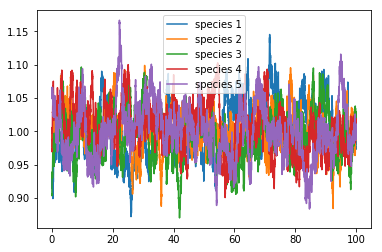

In [3]:
Timeseries=main(seed=1,noise=0.05,sigma=0.05)

In [4]:
ts = fY(Timeseries['timeseries'])[1:]
dts = np.diff(ts)

In [5]:
def HistoSpecies(data,condition=True,title=""):
    nspecies = data.shape[0]
    fig, axs = plt.subplots(1, nspecies, figsize=(2.5*nspecies, 2.5),constrained_layout=True)
    pallet=plt.cm.tab10(np.linspace(0, 1, 12))# use the same color pallet as the lines
    if np.all(condition) == True:
        for i in range(nspecies):
            axs[i].hist(data[i],facecolor=pallet[i+1])
            axs[i].set_title("Species {}".format(i+1))
    else:
        for i in range(nspecies):
            axs[i].hist(data[i][condition[i]],facecolor=pallet[i+1])
            axs[i].set(title="Species {}".format(i+1))
    fig.suptitle(title, fontsize=16)
    plt.show()

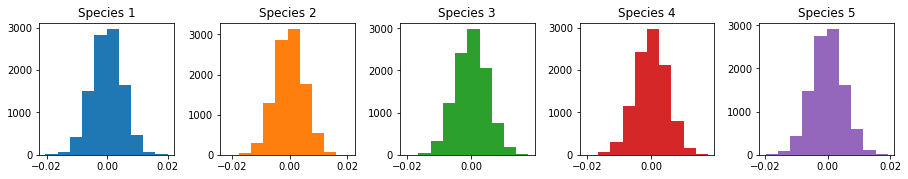

In [6]:
HistoSpecies(dts)

So I find that the time difference is already enourmously gaussion like. And this is without the model removed...

Lets really try to skew this by setting by only looking at data where the species abundance is above the the steadystate.
We should expect a bias to the negative side since in those case the model always tries to pull it down.

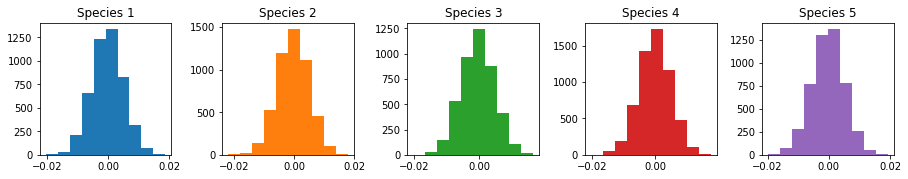

In [7]:
HistoSpecies(dts,ts[:,:-1]>1)

So now we clearly have the condition that we are above the steady state and so the **ONLY** contribution from the model is negatif. -> But we clearly do not see this in the data.

**Edit**: What I stated is false... It can be above equilibrium and still go up because of the second order terms.... so no only negatif is not true... 

For instancle look at:

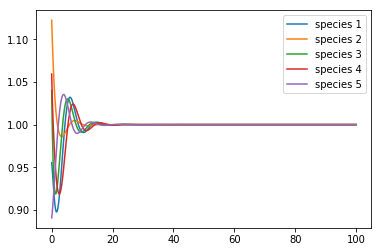

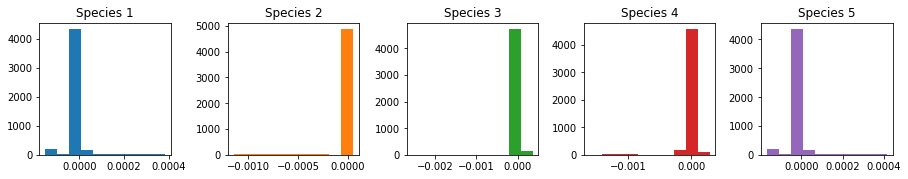

In [8]:
NoNoise=main(seed=1,noise=0.00,sigma=1)
ts_nn = fY(NoNoise['timeseries'])[1:]
dts_nn = np.diff(ts_nn)
HistoSpecies(dts_nn,ts_nn[:,:-1]>1)

But it is however in our case still a good approx since first order term is largely negative. So lets look at some plots where the noise is less prominant.

and maybe some stronger second order terms. Lets try to break gausian form

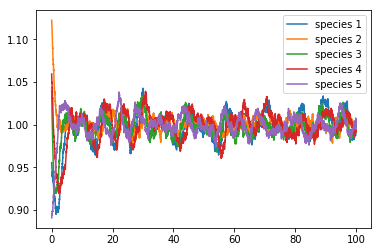

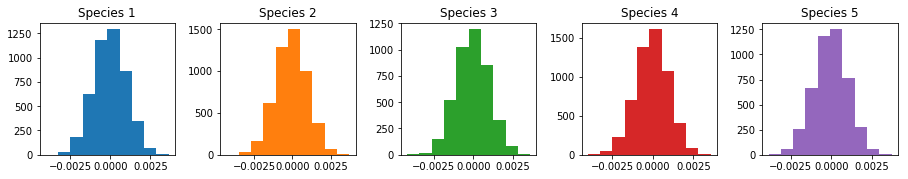

In [9]:
t=main(seed=1,noise=0.01,sigma=1)
ts_ = fY(t['timeseries'])[1:]
dts_ = np.diff(ts_)
HistoSpecies(dts_,ts_[:,:-1]>1)

I cannot seem to break the gaussian shape... unless I really break it like so:

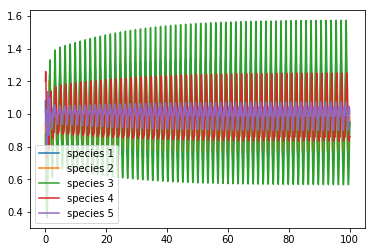

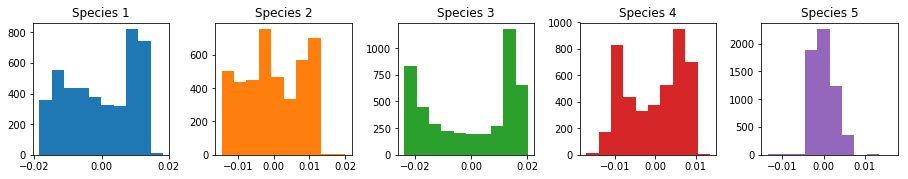

In [10]:
t=main(seed=1,noise=0.0,sigma=5)
ts_ = fY(t['timeseries'])[1:]
dts_ = np.diff(ts_)
HistoSpecies(dts_,ts_[:,:-1]>1)

Let's now really try to disentangle the effects, we can do this in two ways
- One we calculate itself..
- two we get the exact back from the "main" function.

### Disentangle the contribution

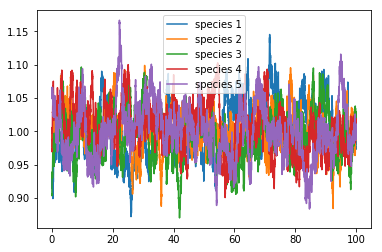

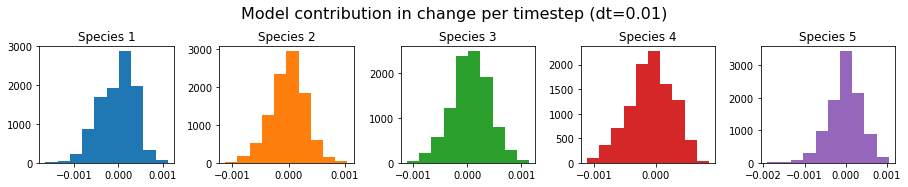

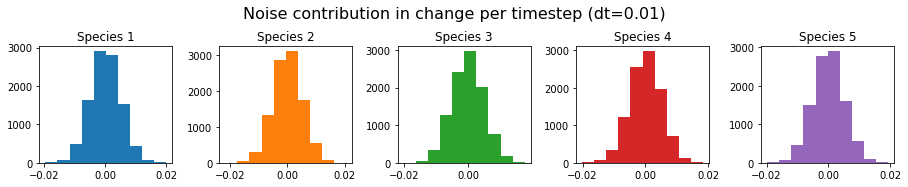

In [46]:
Timeseries=main(seed=1,noise=0.05,sigma=0.05)
dt = Timeseries['timeseries']['time'].values[1] # the first second time reading
InterM = Timeseries['interaction_matrix']
grow = Timeseries['growthrate']
ts = fY(Timeseries['timeseries'])[1:]

gLV = (InterM.dot(ts) * ts + grow * ts) * dt # The gLV contribution of the change
dts = np.diff(ts)
noise =  dts - gLV[:,:-1] # The noise contribution of the change

HistoSpecies(gLV,title="Model contribution in change per timestep (dt={})".format(dt))
HistoSpecies(noise,title="Noise contribution in change per timestep (dt={})".format(dt))

We see that the contribution per time step is **DOMINATED** by noise. Noise is 20 times larger then the contribution of the model. 

To confirm this lets compare this with the ACTUAL gLV and noise contribution that was used in the creation of the timeseries. I updated the main function and it now also gives back those contribution.

True
True


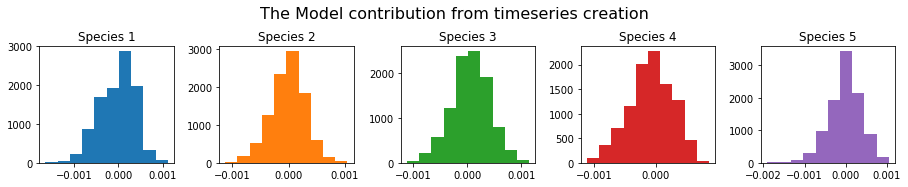

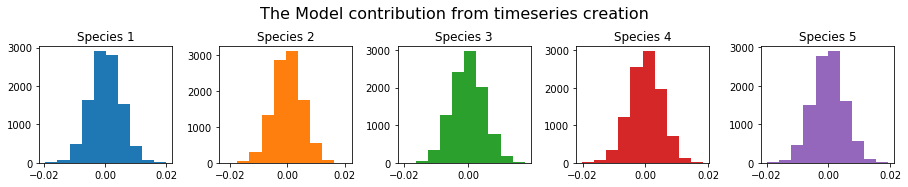

In [12]:
print(np.all(np.round(Timeseries['gLV'],12)==np.round(gLV,12))) # we have to round because there can be a difference in the last hree digits
print(np.all(np.round(Timeseries['noise'][:,:-1],10)==np.round(noise,10)))
HistoSpecies(Timeseries['gLV'],title= "The Model contribution from timeseries creation")
HistoSpecies(Timeseries['noise'],title= "The Model contribution from timeseries creation")

## Cross Validation

We partition the data in to k-equal sized parts where one is the test data. Cycle through the permutations. And compute the average. To this 10 times. 

In [13]:
def TestError(F_test,Y_test,theta_train):
    Avg_error = np.average((F_test-np.dot(theta_train,Y_test))**2)
    Var_error = np.var((F_test-np.dot(theta_train,Y_test))**2)
    return (Avg_error,Var_error)

def Error_CV(Datamatrixes, lambda_M, lambda_mu, k=3, n=10,seed=None,mode = "Table"):
    np.random.seed(seed)
    L = Datamatrixes['F'].shape[1]# number of temporal observation
    L = L-L%k # Max number of temporal observations that is devisible by k 
    F = Datamatrixes['F'][:,:L] # Cut of the last ones else we cannot partition it into k equal sizes
    Y = Datamatrixes['Y'][:,:L]
    D = fD(lambda_mu,lambda_M,F.shape[0])
    Error_table = np.zeros((1,k))
    Var_table = np.zeros((1,k))
    
    for i in range(n):# loop on how often you want to do the cross section
        partition = np.repeat(np.arange(k),L//k)# Partition labels
        np.random.shuffle(partition)# randomize the partition label.
        Error = np.array([])
        Var =  np.array([])
        
        for j in range(k): # loop over all partitions
            Theta_train = SolutionFYD(F=F[:,partition!=j],Y=Y[:,partition!=j],D=D)
            err, va = TestError(F[:,partition==j],Y[:,partition==j],Theta_train)
            Error = np.append(Error,err)
            Var = np.append(Var,va)
        Error_table = np.append(Error_table,Error.reshape(1,k),axis=0)
        Var_table = np.append(Var_table,Var.reshape(1,k),axis=0)
        
    Error_table = Error_table[1:]# Remove the first row that was all zero
    Var_table = Var_table[1:]
    if mode=="Table":
        return (Error_table,Var_table)
    elif mode=="AVG":
        return np.average(Error_table)

vError_CV = np.vectorize(Error_CV)

In [68]:
a=np.repeat(np.arange(3),2)
np.random.shuffle(a)
a

array([1, 1, 0, 2, 2, 0])

In [47]:
F = fF(data=Timeseries['timeseries'])
Y = fY(data=Timeseries['timeseries'])
Theta_r = np.append(Timeseries['growthrate'],Timeseries['interaction_matrix'],axis=1)
DataM = {'F':F,'Y':Y}

In [48]:
Error_table, Var_table = Error_CV(Datamatrixes=DataM, lambda_M=0, lambda_mu=0)
Error_table
# Important! Var_table is not the error on the Mean measurment... 
# Since the var doesn't change if we add more points but to the Mean gets more accurate. 
# The var is a measure that tells us the position of a new entry. 

array([[0.24981881, 0.25142726, 0.25017274],
       [0.24985834, 0.25134386, 0.25057625],
       [0.24726746, 0.2507251 , 0.25346216],
       [0.24685935, 0.25113905, 0.25390544],
       [0.25020457, 0.24926731, 0.25239686],
       [0.24855016, 0.25094383, 0.2517966 ],
       [0.25174654, 0.25079269, 0.24910996],
       [0.24889212, 0.25158134, 0.2513556 ],
       [0.25230608, 0.25133628, 0.24811357],
       [0.24974125, 0.25186529, 0.25002309]])

When calculate the average of averages. We get a pretty stable quanty the three most signifcant digits stay the same. (in the case of both lambdas = 0. 0.250) 

Now loop over all lambda's. And make a figure. 

In [16]:
# take a long time!! (like 5-10 minutes)
lam_M_exp = np.linspace(-6,4,50)
Lam_mu_exp = np.linspace(-6,4,50)
Mesh_lamM, Mesh_lammu = np.meshgrid(np.power(10,lam_M_exp),np.power(10,Lam_mu_exp),)
#Error = vError_CV(Datamatrixes=DataM, lambda_M=Mesh_lamM, lambda_mu=Mesh_lammu, mode = "AVG" ) 
Error=np.load("Errork3n10.npy")

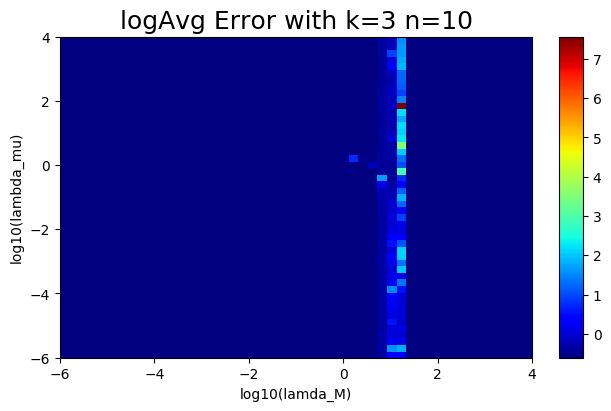

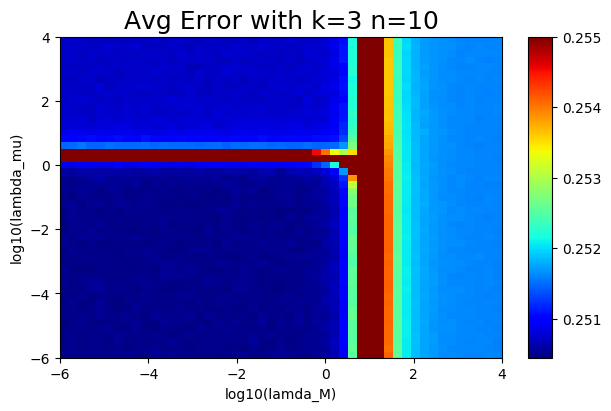

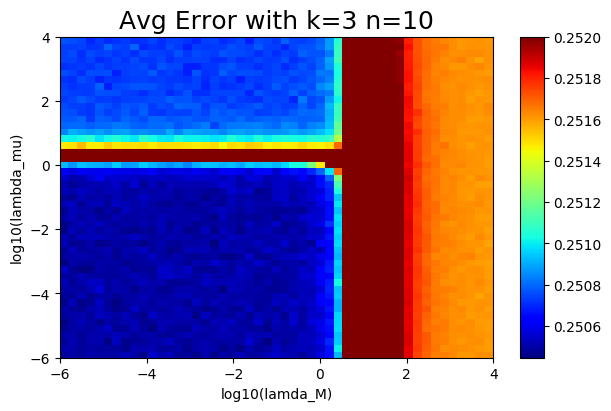

In [17]:
def plotcolormesh(x,y,z,title="",vmax=None,vmin=None,xtext="",ytext="",figsize = None):
    fig = plt.figure(constrained_layout=True,figsize=figsize,dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.pcolormesh(x, y, z, vmax=vmax, vmin=vmin, cmap= "jet")
    plt.title(title,fontsize=18)
    if xtext=="" and ytext=="":
        ax.set(xlabel='log10(lamda_M)', ylabel='log10(lambda_mu)')
    else:
        ax.set(xlabel=xtext, ylabel=ytext)
    fig.colorbar(cax)
    plt.show()

plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=np.log10(Error),title="logAvg Error with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error, vmax=0.255,title="Avg Error with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error, vmax=0.252,title="Avg Error with k=3 n=10")

In [18]:

def total_relatif_error(Theta,Theta_real):
    error = np.abs(Theta-Theta_real)/np.abs(Theta_real)
    return(np.sum(error))

def Avg_relatif_error(Theta,Theta_real):
    error = np.abs(Theta-Theta_real)/np.abs(Theta_real)
    return(np.average(error))

def Median_relatif_error(Theta,Theta_real):
    error = np.abs(Theta-Theta_real)/np.abs(Theta_real)
    return(np.median(error))

def ThetaError_CV(Datamatrixes, realTheta, lambda_M, lambda_mu, ErrorModel=Avg_relatif_error , k=3, n=10,seed=None, mode = "Table"):
    np.random.seed(seed)
    L = Datamatrixes['F'].shape[1]# number of temporal observation
    L = L-L%k # Max number of temporal observations that is devisible by k 
    F = Datamatrixes['F'][:,:L] # Cut of the last ones else we cannot partition it into k equal sizes
    Y = Datamatrixes['Y'][:,:L]
    D = fD(lambda_mu,lambda_M,F.shape[0])
    Error_table = np.zeros((1,k))
    #Var_table = np.zeros((1,k))
    for i in range(n):# loop on how often you want to do the cross section
        partition = np.repeat(np.arange(k),L//k)# Partition labels
        np.random.shuffle(partition)# randomize the partition label.
        Error = np.array([])
        #Var = np.array([])
        for j in range(k): # loop over all partitions
            Theta_train = SolutionFYD(F=F[:,partition!=j],Y=Y[:,partition!=j],D=D)
            err = ErrorModel(Theta_train,realTheta['rTheta'])
            Error = np.append(Error,err)
            #Var = np.append(Var,va)
        Error_table = np.append(Error_table,Error.reshape(1,k),axis=0)
        #Var_table = np.append(Var_table,Var.reshape(1,k),axis=0)
    Error_table = Error_table[1:]# Remove the first row that was all zero
    #Var_table = Var_table[1:]
    
    if mode=="Table":
        return Error_table
        #return (Error_table,Var_table)
    elif mode=="AVG":
        return np.average(Error_table)

vThetaError_CV = np.vectorize(ThetaError_CV)

In [19]:
Error_table = ThetaError_CV(Datamatrixes = DataM, realTheta= {"rTheta":Theta_r}, ErrorModel=Median_relatif_error, mode='AVG', lambda_M=0,lambda_mu=0)
print(Error_table)
np.average(Error_table)

1.4972233305651037


1.4972233305651037

In [20]:
#ParError = vThetaError_CV(Datamatrixes = DataM, lambda_M=Mesh_lamM, lambda_mu=Mesh_lammu, realTheta={"rTheta":Theta_r}, ErrorModel=Median_relatif_error, mode='AVG')
ParError = np.load("ParErrorMediank3n10.npy")

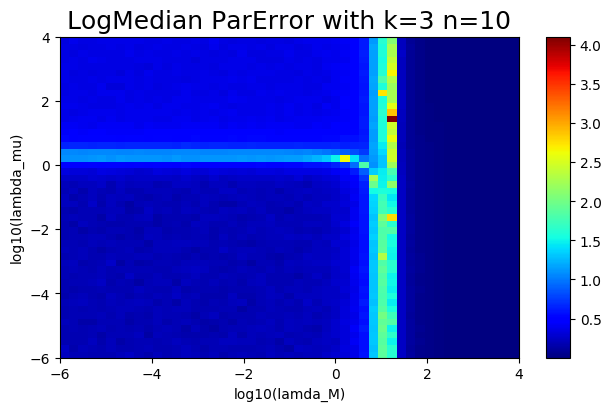

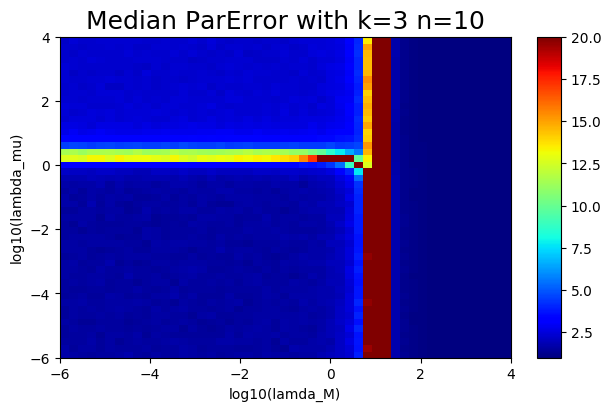

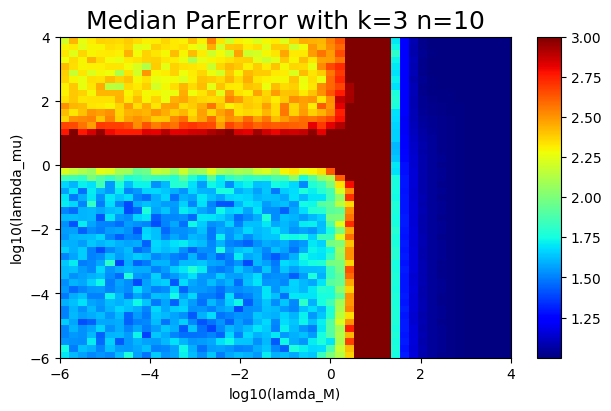

In [21]:
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=np.log10(ParError),title="LogMedian ParError with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=ParError,vmax=20,title="Median ParError with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=ParError,vmax=3,title="Median ParError with k=3 n=10")

We see that the it gets better when going to extreme high lambda_M but ! But it starts to approximate. Which is indeed correct if all the parameter values are equal to zero. Hence everything converges to one. Since the difference is just the real interaction matrix itself. 

So if we want to perform atleast better, we should try to get smaller, then 1 and not just converge to 1.

-> It seems that the < 0, < 0 is the best option. 

In [22]:
#ParError = vThetaError_CV(Datamatrixes = DataM, lambda_M=Mesh_lamM, lambda_mu=Mesh_lammu, realTheta={"rTheta":Theta_r}, ErrorModel=total_relatif_error, mode='AVG')
ParError = np.load("ParErrorTotalk3n10.npy")

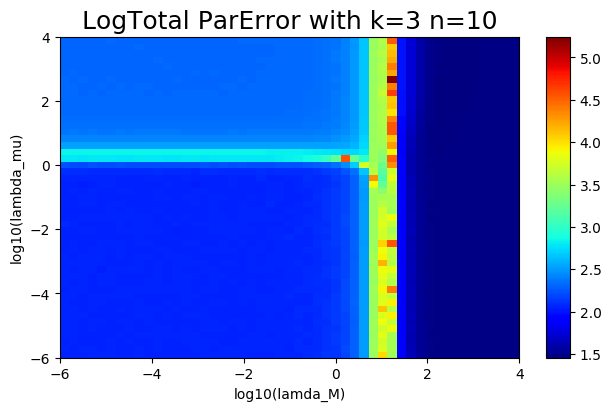

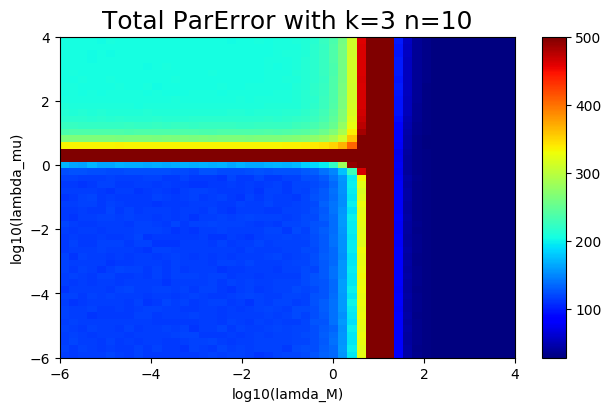

In [23]:
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=np.log10(ParError),title="LogTotal ParError with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=ParError,vmax=500,title="Total ParError with k=3 n=10")

## Condition Good fit

From the previous, we see that whatever the lambda maybe, It does not seem to converge in a good way and our best option for now seems just to be normal least square. 

But we see that we then have median from ~160 % So it seems that we are just not able to converge at all!! It seems to noisy, this is supported by the first part of this week. Where we see that basicly **when our system moves in the phase space on average 95% of the change is duo noise **.

Now lets research when we the noise is at an ok level. 

Things to do:
    - Calculate percentage noise contribution, for different noise and sigma terms.
    - Last week but now with some higher resolution.

In [24]:
def Fraction_noise(Contribution_model, Contribution_noise):
    Model_magnitude = np.linalg.norm(Contribution_model, axis=0)
    Noise_magnitude = np.linalg.norm(Contribution_noise, axis=0)
    FractionNoise = Noise_magnitude/(Model_magnitude + Noise_magnitude) 
    return np.average(FractionNoise)
    
def plotFraction(Contribution_model,Contribution_noise,title=""):
    Model_magnitude = np.linalg.norm(Contribution_model, axis=0)
    Noise_magnitude = np.linalg.norm(Contribution_noise, axis=0)
    FractionNoise = Noise_magnitude/(Model_magnitude + Noise_magnitude) 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(FractionNoise)
    plt.title(title,fontsize=18)
    plt.show()

In [25]:
Timeseries=main(seed=1,noise=0.05,sigma=0.05,plot=False)# Generate again the timeseries

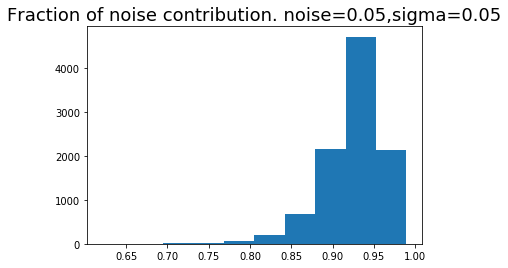

0.9252441357526342

In [26]:
plotFraction(Timeseries['gLV'],Timeseries['noise'],title="Fraction of noise contribution. noise=0.05,sigma=0.05")
Fraction_noise(Timeseries['gLV'],Timeseries['noise'])

Now lets vary the noise level and sigma to see where we can find an optimal fraction and maybe there we can try to infer the matrix.

In [27]:
def FractionGrid(noise,sigma,mode="Fraction"):
    Fraction = np.zeros((1,len(sigma)))
    if mode=="Errors" or mode=="PredError":
        MedErr = np.zeros((1,len(sigma)))
        TotErr = np.zeros((1,len(sigma)))
        if mode=="PredError":
            PredErr = np.zeros((1,len(sigma)))
    len_s = len(sigma)
    len_n = len(noise)
    nloops = len_s*len_n
    
    #Timing stuff
    PrintEvery = 100
    StartTime = time.time()
    Time = StartTime # Just put this on start for now
    TimeSplits=np.array([])
    for i,n in enumerate(noise): # by doing n as the first loop -> we must take it as the y-axis in the plot
        Fraction_row = np.array([])
        if mode=="Errors" or mode=="PredError":
            MedErr_row = np.array([])
            TotErr_row = np.array([])
            if mode=="PredError":
                PredErr_row = np.array([])
        for j,s in enumerate(sigma):
            # Make prints
            itter=i*len_s+j
            if itter%PrintEvery==0:# Do the time stuff to give the user an idea how long it is going to last
                # Do the time calculations
                NewTime = time.time()
                if itter!=0:
                    TimeSplits = np.append(TimeSplits,NewTime-Time)
                Time = NewTime
                AvgTime = round( np.average(TimeSplits),2 )
                EstimateTimeleft = (nloops-itter)/PrintEvery*AvgTime # numberItter_left/100 * time to take 100 itter
                TimeElapsed = np.round( Time - StartTime, 2)
                # The time prints
                sys.stdout.write("\r")
                sys.stdout.write("At itteration = {} , Time elapsed = {} min. AvgTime/{}itter = {} sec. Estimated time left = {} min".format(itter,round(TimeElapsed/60,2),PrintEvery,AvgTime,round(EstimateTimeleft/60,2)))
                sys.stdout.write("\n")# create a newline to medigate the return that follows
            sys.stdout.write("\r")
            sys.stdout.write("Loop {}/{} = {}%".format(itter, nloops, np.floor(itter/nloops*100)))
            
            # The actual calculations
            ts=main(noise=n,sigma=s,plot=False)
            Fraction_row = np.append(Fraction_row, Fraction_noise(ts['gLV'],ts['noise']))
            if mode=="Errors" or mode=="PredError":# Parameter errors
                theta_r = np.append(ts['growthrate'],ts['interaction_matrix'],axis=1)
                F_ = fF(data=ts['timeseries'])
                Y_ = fY(data=ts['timeseries'])
                DataM_ = {'F':F_,'Y':Y_}
                try:# The following two can throw errors so catch them to not break the loop
                    Mederr = ThetaError_CV(Datamatrixes = DataM_, realTheta= {"rTheta":theta_r}, ErrorModel=Median_relatif_error, mode='AVG', lambda_M=0,lambda_mu=0)
                    Toterr = ThetaError_CV(Datamatrixes = DataM_, realTheta= {"rTheta":theta_r}, ErrorModel=total_relatif_error, mode='AVG', lambda_M=0,lambda_mu=0)
                except:
                    Mederr = np.inf# if the calculation failed -> set the error to infinity. 
                    Toterr = np.inf
                MedErr_row = np.append(MedErr_row,Mederr)
                TotErr_row = np.append(TotErr_row,Toterr)
                if mode=="PredError":
                    try:
                        Prederr = Error_CV(Datamatrixes=DataM_, lambda_M=0, lambda_mu=0, mode = "AVG" )
                    except:
                        Prederr = np.inf
                    PredErr_row = np.append(PredErr_row,Prederr)
            
        Fraction = np.append(Fraction,Fraction_row.reshape(1,len(sigma)),axis=0)
        if mode=="Errors" or mode=="PredError":
            MedErr = np.append(MedErr,MedErr_row.reshape(1,len(sigma)),axis=0)
            TotErr = np.append(TotErr,TotErr_row.reshape(1,len(sigma)),axis=0)
            if mode=="PredError":
                PredErr = np.append(PredErr,PredErr_row.reshape(1,len(sigma)),axis=0)
        
    sys.stdout.write("\r Finished!")
    Fraction = Fraction[1:]
    if mode=="Errors" or mode=="PredError":
        MedErr = MedErr[1:]
        TotErr = TotErr[1:]
        if mode=="PredError":
            PredErr = PredErr[1:]
    MeshS, MeshN = np.meshgrid(sigma,noise)
    if mode=="Fraction":
        return (MeshS,MeshN,Fraction)
    elif mode=="Errors":
        return (MeshS,MeshN,Fraction,MedErr,TotErr)
    elif mode=="PredError":
        return (MeshS,MeshN,Fraction,MedErr,TotErr,PredErr)

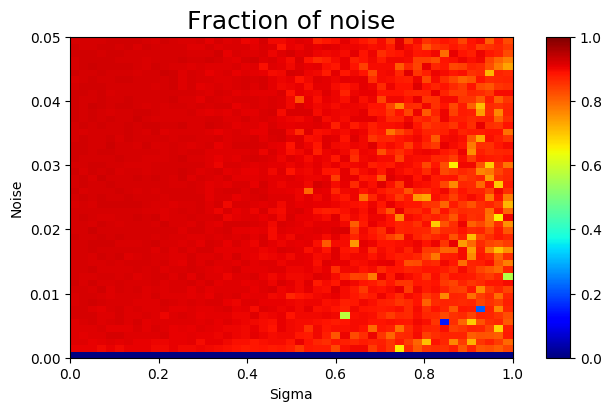

In [28]:
noise = np.linspace(0,0.05,50)
sigma = np.linspace(0,1,50)
MeshS, MeshN = np.meshgrid(sigma,noise)
#MeshS, MeshN, Fraction = FractionGrid(noise,sigma)# for 50,50 takes a long time... 40 mins roughly
Fraction = np.load("Fraction_s1_n005.npy") # noise = np.linspace(0,0.05,50) sigma = np.linspace(0,1,50)
plotcolormesh(x=MeshS, y=MeshN, z=Fraction,vmin=0, vmax=1, title="Fraction of noise",xtext="Sigma",ytext="Noise")

Results: We see that when noise=0 -> We have 0 % fraction of noise. But already from the first just a bit a bit off noise we get. Jup in the 70%> terrain of noise.

We actually do not see that much differnence from the noise, maybe just add the edge of the 0 it is a lighter shade of red. 

What does have an influance is the sigma ! -> The higher the sigma, the lower the fraction goes. What I am interested in know is:
    - Further enhance the transition in the noise
    - look at how far we can go with the sigma
    - Look at the log relation of the noise vs sigma instead of the just noise
    - Now do the same, but now compute the error. (with already ideal lamda) and see if the error improves
    - Once we found an ideal point -> See if the conclusion we made about lamda above still holds up.


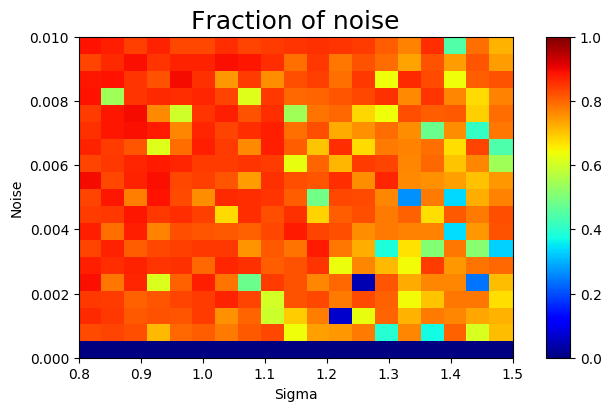

In [29]:
noise = np.linspace(0,0.01,20)
sigma = np.linspace(0.8,1.5,20)
MeshS, MeshN = np.meshgrid(sigma,noise)
#MeshS, MeshN, Fraction = FractionGrid(noise,sigma)
Fraction = np.load("Fraction_s15_n001.npy") # noise = np.linspace(0,0.01,20) sigma = np.linspace(0.8,1.5,20)
plotcolormesh(x=MeshS, y=MeshN, z=Fraction,vmin=0, vmax=1, title="Fraction of noise",xtext="Sigma",ytext="Noise")

We still see a strong jump from 0 noise to imidiatly 70% noise. So we should investigate the logarithm. 

Those two blue outliers are now gone. But we do see taht we get more blueish color for higher and higher noise. 

Here it is not clear if there is a noise gradient or not. 

### Exploration big areas
    - Part 1: First just a larger sigma window, and we also now calculate the Parameter error not just fractions
    - Part 2: To get rid of the sharp contrast of the first line -> Explore the log(noise) 
    - Part 3: Larger window as Part2, But and also prediction error now. 

### Part 1

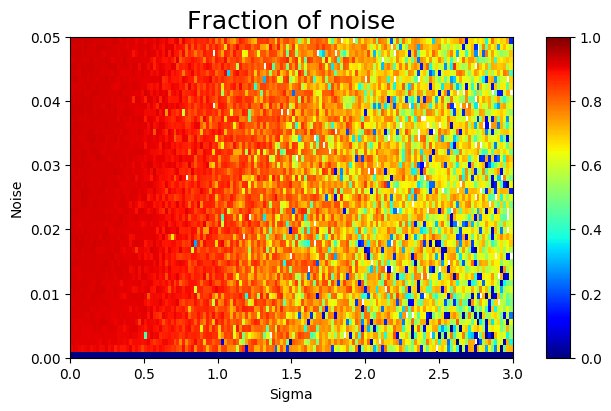

In [53]:
noise = np.linspace(0,0.05,50)
sigma = np.linspace(0,3,150)
MeshS, MeshN = np.meshgrid(sigma,noise)
#MeshS, MeshN, Fraction, Median, Total = FractionGrid(noise,sigma,mode="Errors") # Time elapsed = 223.68 min. AvgTime/100itter = 181.36 sec. Estimated time left = 3.02 min
Fraction = np.load("Fraction_s3_n05.npy") # noise = np.linspace(0,0.05,50) sigma = np.linspace(0,3,150)
Median = np.load("Median_s3_n05.npy")
Total = np.load("Total_s3_n05.npy")
plotcolormesh(x=MeshS, y=MeshN, z=Fraction,vmin=0, vmax=1, title="Fraction of noise",xtext="Sigma",ytext="Noise")

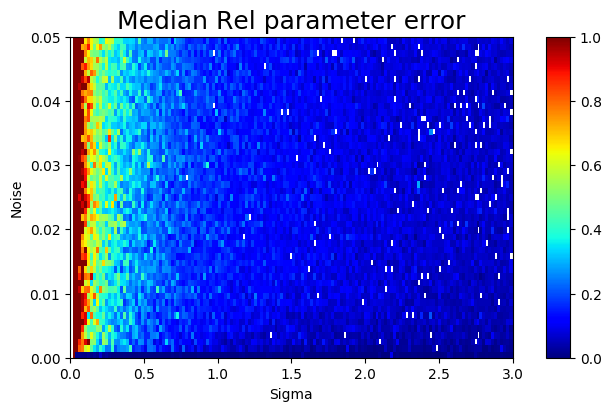

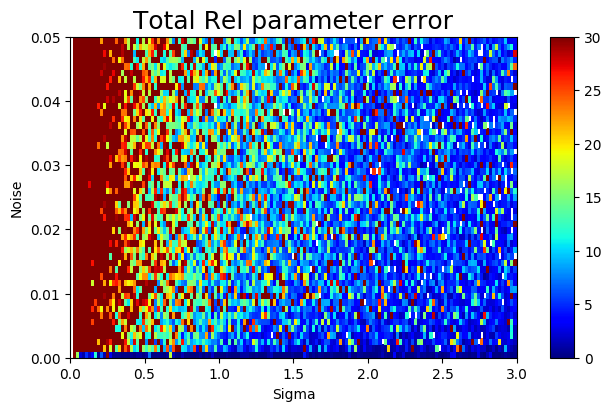

In [54]:
plotcolormesh(x=MeshS, y=MeshN, z=Median,vmin=0, vmax=1, title="Median Rel parameter error",xtext="Sigma",ytext="Noise")
plotcolormesh(x=MeshS, y=MeshN, z=Total,vmin=0, vmax=30, title="Total Rel parameter error",xtext="Sigma",ytext="Noise")

Next I want to do again a big calculation but now with noise in log form because I really want to see the transition from good to extremely bad. 

### Part 2

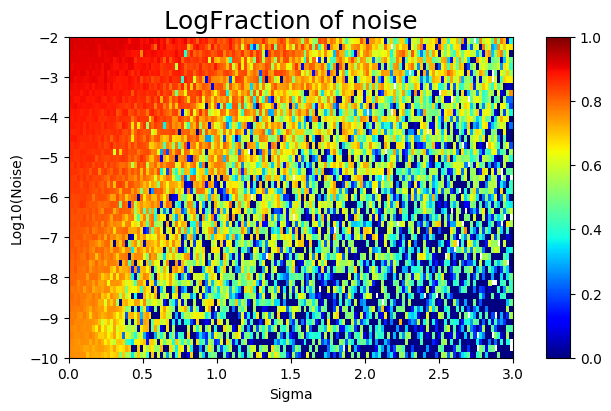

In [32]:
noise_exp = np.linspace(-10,-2,50)
noise = np.power(10,noise_exp)
sigma = np.linspace(0,3,150)
MeshS, MeshN = np.meshgrid(sigma,noise)
# MeshS, MeshN, Fraction, Median, Total = FractionGrid(noise,sigma,mode="Errors")
Fraction = np.load("LogFraction_s3_n2.npy") # noise = np.linspace(0,0.05,50) sigma = np.linspace(0,3,150)
Median = np.load("LogMedian_s3_n2.npy")
Total = np.load("LogTotal_s3_n2.npy")
plotcolormesh(x=sigma, y=noise_exp, z=Fraction,vmin=0, vmax=1, title="LogFraction of noise",xtext="Sigma",ytext="Log10(Noise)")

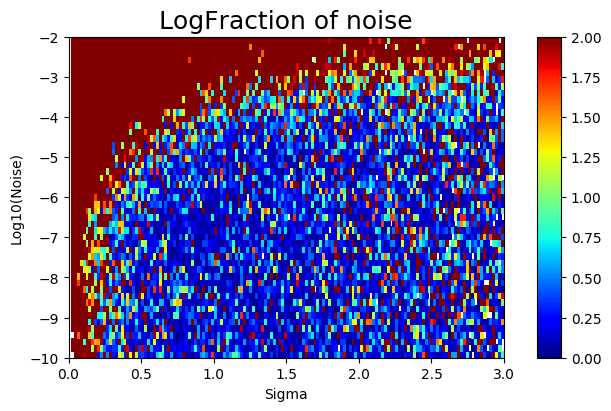

In [33]:
Total_=np.load("LogTotal_s3_n2.npy")
plotcolormesh(x=sigma, y=noise_exp, z=Total_,vmin=0, vmax=2, title="LogFraction of noise",xtext="Sigma",ytext="Log10(Noise)")

### Part 3

In [56]:
noise_exp = np.linspace(-10,0,100)
noise = np.power(10,noise_exp)
sigma = np.linspace(0,5,250)
MeshS, MeshN = np.meshgrid(sigma,noise)
#MeshS, MeshN, Fraction, Median, Total, PredErr = FractionGrid(noise,sigma,mode="PredError") took +- 12 hours
Fraction = np.load("largeLogFraction.npy") #noise_exp = np.linspace(-10,0,100) noise = np.power(10,noise_exp) sigma = np.linspace(0,5,250)
Median = np.load("largeLogMedian.npy")
Total = np.load("largeLogTotal.npy")
PredErr = np.load("largeLogPredErr.npy")

Now that we have made the big calculation we can explore the the spaces where the conditions are good for infering the model. First just look at the fraction of noise.

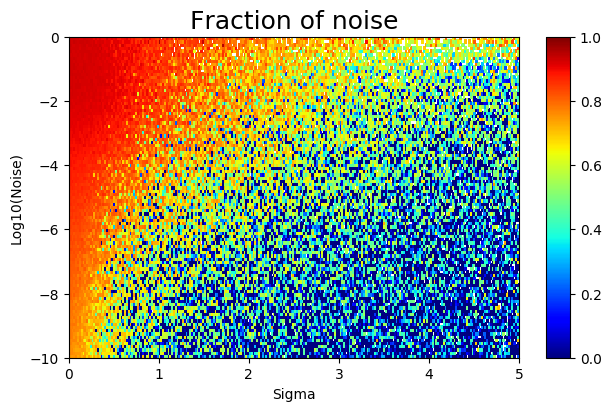

In [57]:
plotcolormesh(x=sigma, y=noise_exp, z=Fraction,vmin=0, vmax=1, title="Fraction of noise",xtext="Sigma",ytext="Log10(Noise)")

Notice before we where in the region noise = 0.05 sigma =0.05 -> This is the deep red zone, So here it is really bad ! 

Now look at parameter predictions: 

**Median**: Remeber this is relatif. So a median off 0.01 Means that at least half of the parameters have a aproximated it by the real with an error of less then 1%

**Total**: Here we count up the total relatif error. We need to remember here that there are 30 parameters. So 30 is an intersting point since what it means 
    - to have a smaller total then 30 means that on average the aproximation of the parameters have got the correct magnitude. And that there are not giant outliers. 
    - A total error of < 1 means that NO parameters is seperatered by a magnitude of the paramter.

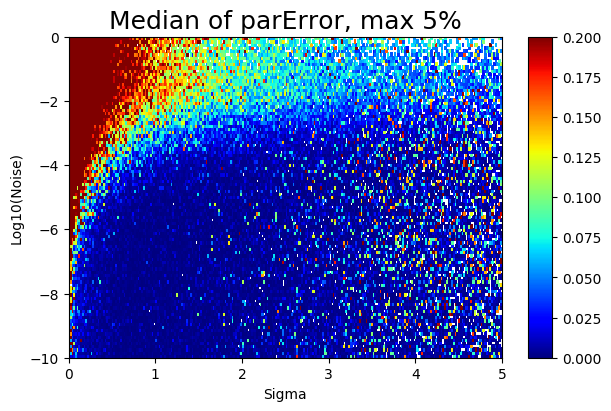

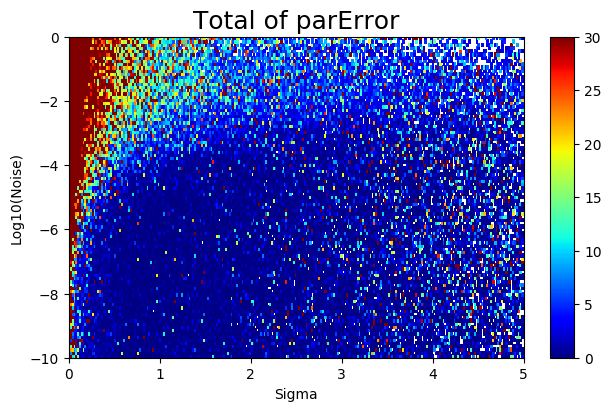

In [58]:
plotcolormesh(x=sigma, y=noise_exp, z=Median,vmin=0, vmax=0.2, title="Median of parError, max 5%",xtext="Sigma",ytext="Log10(Noise)")
plotcolormesh(x=sigma, y=noise_exp, z=Total,vmin=0, vmax=30, title="Total of parError",xtext="Sigma",ytext="Log10(Noise)")

Next look at the prediction error we make. 

The computed PredError has a big draw back!!
The error that is computed is $ avg(|F-\theta Y|^2_2)$ rather then $ total(|F-\theta Y|^2_2)$. This was done because at the before I did this whole exploration the Total prediction error was quite large, And no where close the small number that was shown in the paper. 

But now with the knowledge of the sigma vs log(noise), we know that we where just in an awfull condition, to be. So maybe in the case of better conditions. The total will be much better, Thats and also the average will be. 

At the other side, the total DOES depend on the amount of data they uses... which I do not know of the paper. However I with our 5* 10 000 point I know that the average will need to be. 6e-5 in order to get the same order of total error in as in the paper. 

With that being said lets now evalutate the total prediction error normalised by amount of observation times species. (Maybe one should take the log)
Remember to get the total one should just multiply by 50 000 (actually maybe do that in one the plots)

Actually when multipling by 50 000 it is just to raise the whole thing by a constant since log(50 000 * PredErr) = log(50 000)+ log(PredErr)

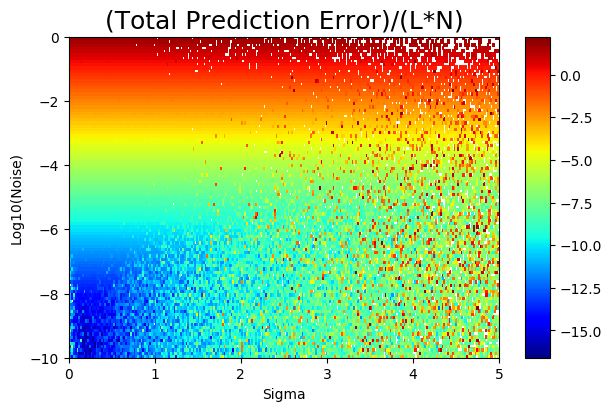

In [37]:
plotcolormesh(x=sigma, y=noise_exp, z=np.log10(PredErr),vmin=None, vmax=None, title="(Total Prediction Error)/(L*N)",xtext="Sigma",ytext="Log10(Noise)")

Results:

->  From the Parameter Error (wich is really what we care for) We see that there is this exponatial curve, when we go below that it our conditions are good. Also it seems that the slope of the log(sigma) depends on the value (green is is steeper). 

-> We found an optimal for the Parameter error at noise=e-6 and sigma = 1. One would think with the exp curve that we should go to the lower right corner. However For higher sigma a new problem arises (independelty for noise apperent) system becomes unstable and one get weird outliers. (at the high noise regime these result in overflows) but sigma 2 and unwards it becomes more normal to see these weird outliers. 

-> We note that the optimal point for par error does not correspond with the optimal in fraction. Actually at that point fraction is on average still quite high: +- 0.6 

-> Next we look at the prediction error. Weirdly here we do not recognize at all the a expo relation. but just a uniform gradient descent downwards. However this changes from noise < e-6 where higher sigma results in clearly worse prediction ( not related to the outliers). The optimal here lies in small sigma (but not zero) and as small as possible noise

# Redo the lambda analysis
What now is left to do, is to redo the lambda analysis but now at a point where we know it is fair game ! And do not lie far above the expo line. 

Do this analysis for different conditions:
    - Sigma= 0.05, noise = 0.05 (this was already done before)
    - The ideal condition Sigma = 1 and noise = 1e-6. This situtation is unrealistic but lets investigate non the less
    - Paper condition. We know from the paper that it had a total error 3... (we don't the size of the experiment) but lets say 1000 meaning we are looking at a size an average error 1e-3. For us this is the yellow region at noise 1e-3. We can still decide on the sigma. For 1e-3 we are on the 5% error curve with sigma 1.5, But lets just stick with sigma 1.

## ideal condition. 

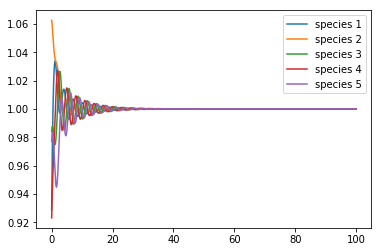

In [38]:
# Generate the time series and define some associating matrixes
Timeseries=main(seed=3,noise=1e-6,sigma=1)# Seed 3 was chose because of the noise distrubition. But one should play arround.
F = fF(data=Timeseries['timeseries'])
Y = fY(data=Timeseries['timeseries'])
Theta_r = np.append(Timeseries['growthrate'],Timeseries['interaction_matrix'],axis=1)
DataM = {'F':F,'Y':Y}
# Play arround with seed None to see what kind of models you get. 

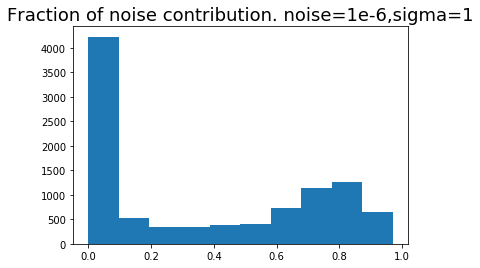

0.3641593394920524

In [39]:
# Have a look at the noise distribution
plotFraction(Timeseries['gLV'],Timeseries['noise'],title="Fraction of noise contribution. noise=1e-6,sigma=1")
Fraction_noise(Timeseries['gLV'],Timeseries['noise'])

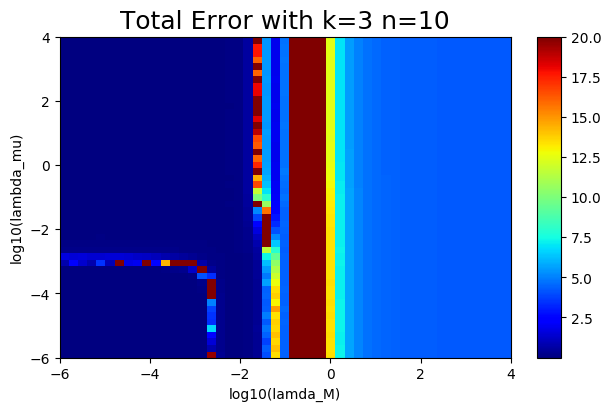

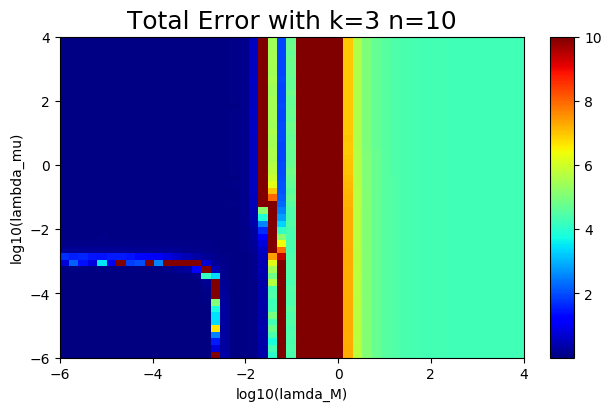

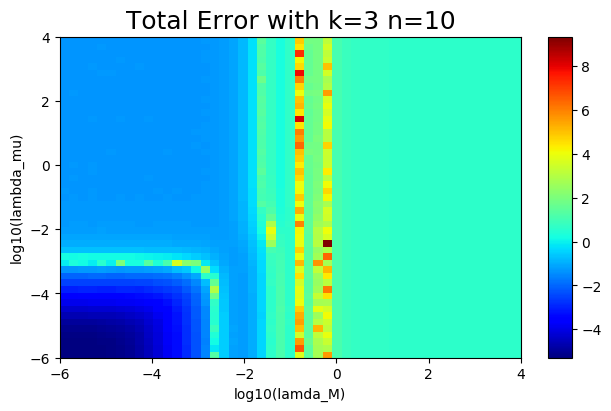

In [63]:
# Calculate the lambdda dependens
lam_M_exp = np.linspace(-6,4,50)
Lam_mu_exp = np.linspace(-6,4,50)
Mesh_lamM, Mesh_lammu = np.meshgrid(np.power(10,lam_M_exp),np.power(10,Lam_mu_exp),)
#Error = vError_CV(Datamatrixes=DataM, lambda_M=Mesh_lamM, lambda_mu=Mesh_lammu, mode = "AVG" ) 
Error = np.load("ErrorvsLambda_ideal.npy")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error*50000,vmax=20,title="Total Error with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error*50000,vmax=10,title="Total Error with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=np.log10(Error*50000),vmax=None,title="Total Error with k=3 n=10")

Result: 
We do not recover the paper and least square is still the best option.

## Paper conditions

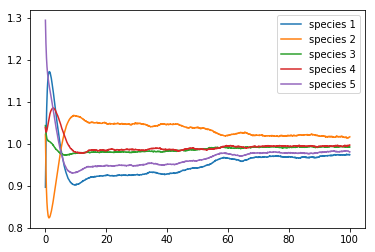

In [69]:
# Generate the time series and define some associating matrixes
Timeseries=main(seed=None,noise=1e-3,sigma=1)
F = fF(data=Timeseries['timeseries'])
Y = fY(data=Timeseries['timeseries'])
Theta_r = np.append(Timeseries['growthrate'],Timeseries['interaction_matrix'],axis=1)
DataM = {'F':F,'Y':Y}
# Play arround with seed None to see what kind of models you get. 

Here we do see noise arround a steady state. (The initial off set is maybe a bit to large...) But Hey we are now dealing with this... I don't think it has that much of an influance. 

But we do still nicely see error contribution. small fluctations of the data.

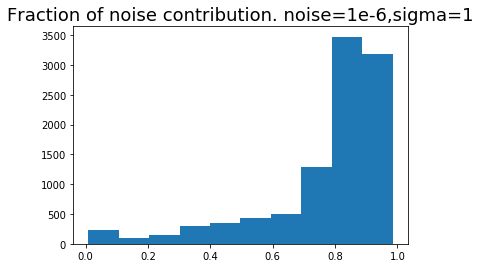

0.771439810502963

In [42]:
# Have a look at the noise distribution
plotFraction(Timeseries['gLV'],Timeseries['noise'],title="Fraction of noise contribution. noise=1e-6,sigma=1")
Fraction_noise(Timeseries['gLV'],Timeseries['noise'])

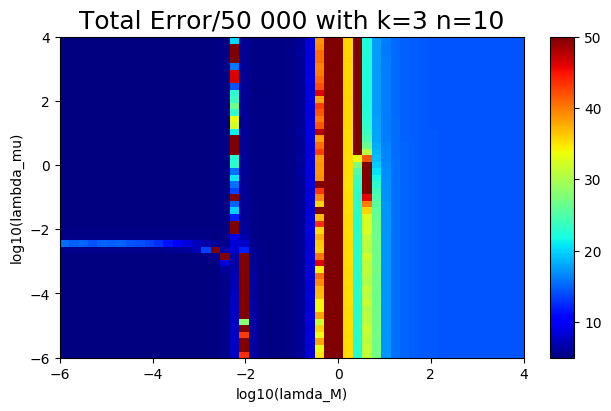

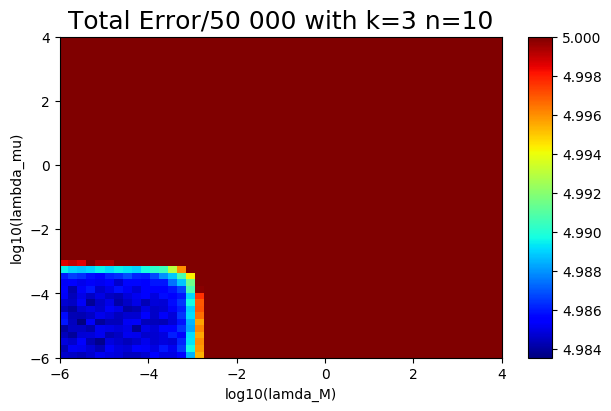

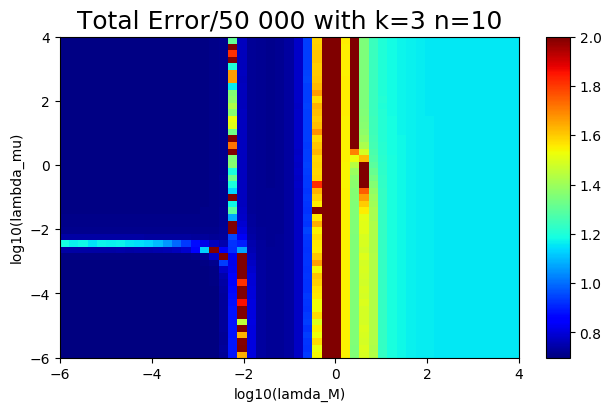

In [43]:
# Calculate the lambdda dependens
lam_M_exp = np.linspace(-6,4,50)
Lam_mu_exp = np.linspace(-6,4,50)
Mesh_lamM, Mesh_lammu = np.meshgrid(np.power(10,lam_M_exp),np.power(10,Lam_mu_exp),)
# Error = vError_CV(Datamatrixes=DataM, lambda_M=Mesh_lamM, lambda_mu=Mesh_lammu, mode = "AVG" ) 
Error = np.load("ErrorvsLambda_Paper.npy")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error*50000,vmax=50,title="Total Error/50 000 with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=Error*50000,vmax=5,title="Total Error/50 000 with k=3 n=10")
plotcolormesh(x=lam_M_exp, y=Lam_mu_exp, z=np.log10(Error*50000),vmax=2,title="Total Error/50 000 with k=3 n=10")